In [60]:
%load_ext autoreload
%autoreload all

from datetime import date, datetime, timedelta
import pandas as pd
from numpy import float16, float64

from simulator.binance.binance_k_line_repository import load_k_lines


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
interval_date_from = date(2023, 5, 1)
interval_date_to = date(2023, 5, 31)
symbol: str = "ETHUSDT"
prediction_window_minutes = 15

In [62]:
raw_k_lines = load_k_lines(symbol, interval_date_from, interval_date_to)

display(raw_k_lines)

,open_timestamp_millis,open_price,high_price,low_price,close_price,volume,close_timestamp_millis,quote_asset_volume,trades_count,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,1682899200000,1868.41,1871.06,1867.20,1869.44,20316.217,1682899259999,3.797542e+07,11692,11552.083,2.159521e+07,0
1,1682899260000,1869.44,1875.64,1869.34,1875.63,19738.657,1682899319999,3.698278e+07,10552,12767.284,2.391795e+07,0
2,1682899320000,1875.64,1875.64,1872.80,1872.80,12220.644,1682899379999,2.290880e+07,6146,4005.436,7.507829e+06,0
3,1682899380000,1872.81,1877.26,1872.55,1877.26,7275.710,1682899439999,1.364297e+07,6926,5023.121,9.419046e+06,0
4,1682899440000,1877.26,1881.39,1876.84,1880.40,14390.501,1682899499999,2.704258e+07,9779,9616.647,1.807247e+07,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1435,1685577300000,1873.17,1874.41,1873.08,1874.41,4202.478,1685577359999,7.873024e+06,1590,2667.404,4.997601e+06,0
1436,1685577360000,1874.40,1874.41,1872.54,1872.80,3444.416,1685577419999,6.454170e+06,1565,401.812,7.527455e+05,0
1437,1685577420000,1872.81,1873.44,1872.64,1872.84,1423.699,1685577479999,2.666499e+06,1428,820.822,1.537314e+06,0
1438,1685577480000,1872.84,1872.95,1872.53,1872.83,820.012,1685577539999,1.535584e+06,910,353.406,6.618053e+05,0


In [63]:
from poc.bot_ml.poc_bot_ml_utils import to_cleared_k_lines

k_lines = to_cleared_k_lines(raw_k_lines)
display(k_lines)

,close_price
open_datetime,
2023-05-01 00:00:00,1869.44
2023-05-01 00:01:00,1875.63
2023-05-01 00:02:00,1872.80
2023-05-01 00:03:00,1877.26
2023-05-01 00:04:00,1880.40
...,...
2023-05-31 23:55:00,1874.41
2023-05-31 23:56:00,1872.80
2023-05-31 23:57:00,1872.84


In [64]:
from poc.bot_ml.poc_bot_ml_utils import validate_k_lines


validate_k_lines(k_lines, interval_date_from, interval_date_to)

<Axes: xlabel='open_datetime'>

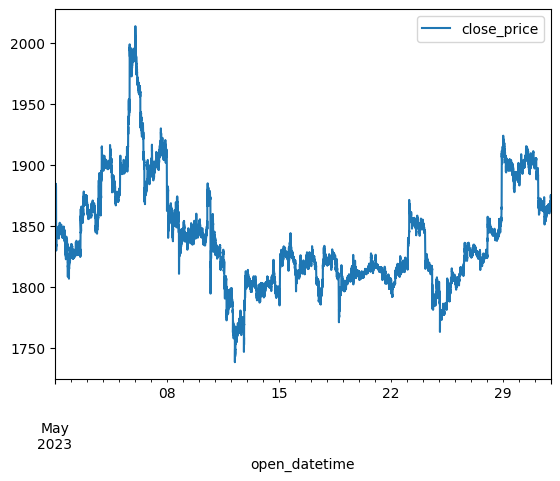

In [65]:
k_lines.plot.line(use_index=True, )

In [66]:
from poc.bot_ml.poc_bot_ml_utils import calculate_and_set_target_action_feature

features = k_lines.copy()

calculate_and_set_target_action_feature(features, prediction_window_minutes, 1.0 + 0.001)

features.dropna(inplace=True)

display(features.tail(20))

,close_price,target_action,target_action_name
open_datetime,,,
2023-05-31 23:25:00,1870.02,0.0,0.0 - a
2023-05-31 23:26:00,1869.47,0.0,0.0 - a
2023-05-31 23:27:00,1870.24,0.0,0.0 - a
2023-05-31 23:28:00,1871.01,1.0,1.0 - a
2023-05-31 23:29:00,1871.10,1.0,1.0 - a
2023-05-31 23:30:00,1870.67,1.0,1.0 - a
2023-05-31 23:31:00,1870.61,1.0,1.0 - a
2023-05-31 23:32:00,1870.16,1.0,1.0 - a
2023-05-31 23:33:00,1870.28,1.0,1.0 - a


In [67]:
from pandas import DataFrame
from poc.bot_ml.poc_bot_ml_utils import calculate_interval_hours


display(
    DataFrame(
        {
            "target_actions_count": features["target_action"].value_counts(),
            "target_actions_ratio": features["target_action"].value_counts()
            / len(features),
            "target_actions_per_hour": features["target_action"].value_counts()
            / calculate_interval_hours(interval_date_from, interval_date_to),
        }
    )
)

,target_actions_count,target_actions_ratio,target_actions_per_hour
1.0,15429,0.345864,20.737903
-1.0,15341,0.343892,20.619624
0.0,13840,0.310244,18.602151


<Axes: xlabel='open_datetime', ylabel='close_price'>

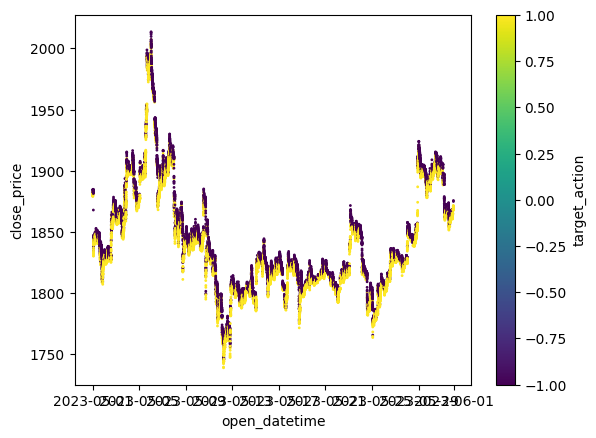

In [68]:
features[features["target_action"] != 0].reset_index().plot.scatter(
    x="open_datetime", y="close_price", c="target_action", s=1.0
)